In [2]:
! pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 30.7 MB/s eta 0:00:00 0:00:01


Using MPS (Apple Silicon GPU)
Training samples: 60000, Test samples: 10000
Training VAE on Fashion MNIST...
Epoch 1 [0/60000 (0%)]	Loss: 695.602478
Epoch 1 [25600/60000 (43%)]	Loss: 292.128357
Epoch 1 [51200/60000 (85%)]	Loss: 245.735077
Epoch 1: Average loss: 319.1437, Beta: 0.050
Validation Loss: 270.4314
Current learning rate: 0.005
Epoch 2 [0/60000 (0%)]	Loss: 253.104599
Epoch 2 [25600/60000 (43%)]	Loss: 245.982971
Epoch 2 [51200/60000 (85%)]	Loss: 245.170807
Epoch 2: Average loss: 243.7782, Beta: 0.100
Validation Loss: 248.8871
Current learning rate: 0.005
Epoch 3 [0/60000 (0%)]	Loss: 247.257736
Epoch 3 [25600/60000 (43%)]	Loss: 235.091248
Epoch 3 [51200/60000 (85%)]	Loss: 223.362900
Epoch 3: Average loss: 235.6129, Beta: 0.150
Validation Loss: 238.8225
Current learning rate: 0.005
Epoch 4 [0/60000 (0%)]	Loss: 237.275787
Epoch 4 [25600/60000 (43%)]	Loss: 237.822357
Epoch 4 [51200/60000 (85%)]	Loss: 232.892197
Epoch 4: Average loss: 231.5259, Beta: 0.200
Validation Loss: 239.0691
C

/opt/anaconda3/envs/AISE/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


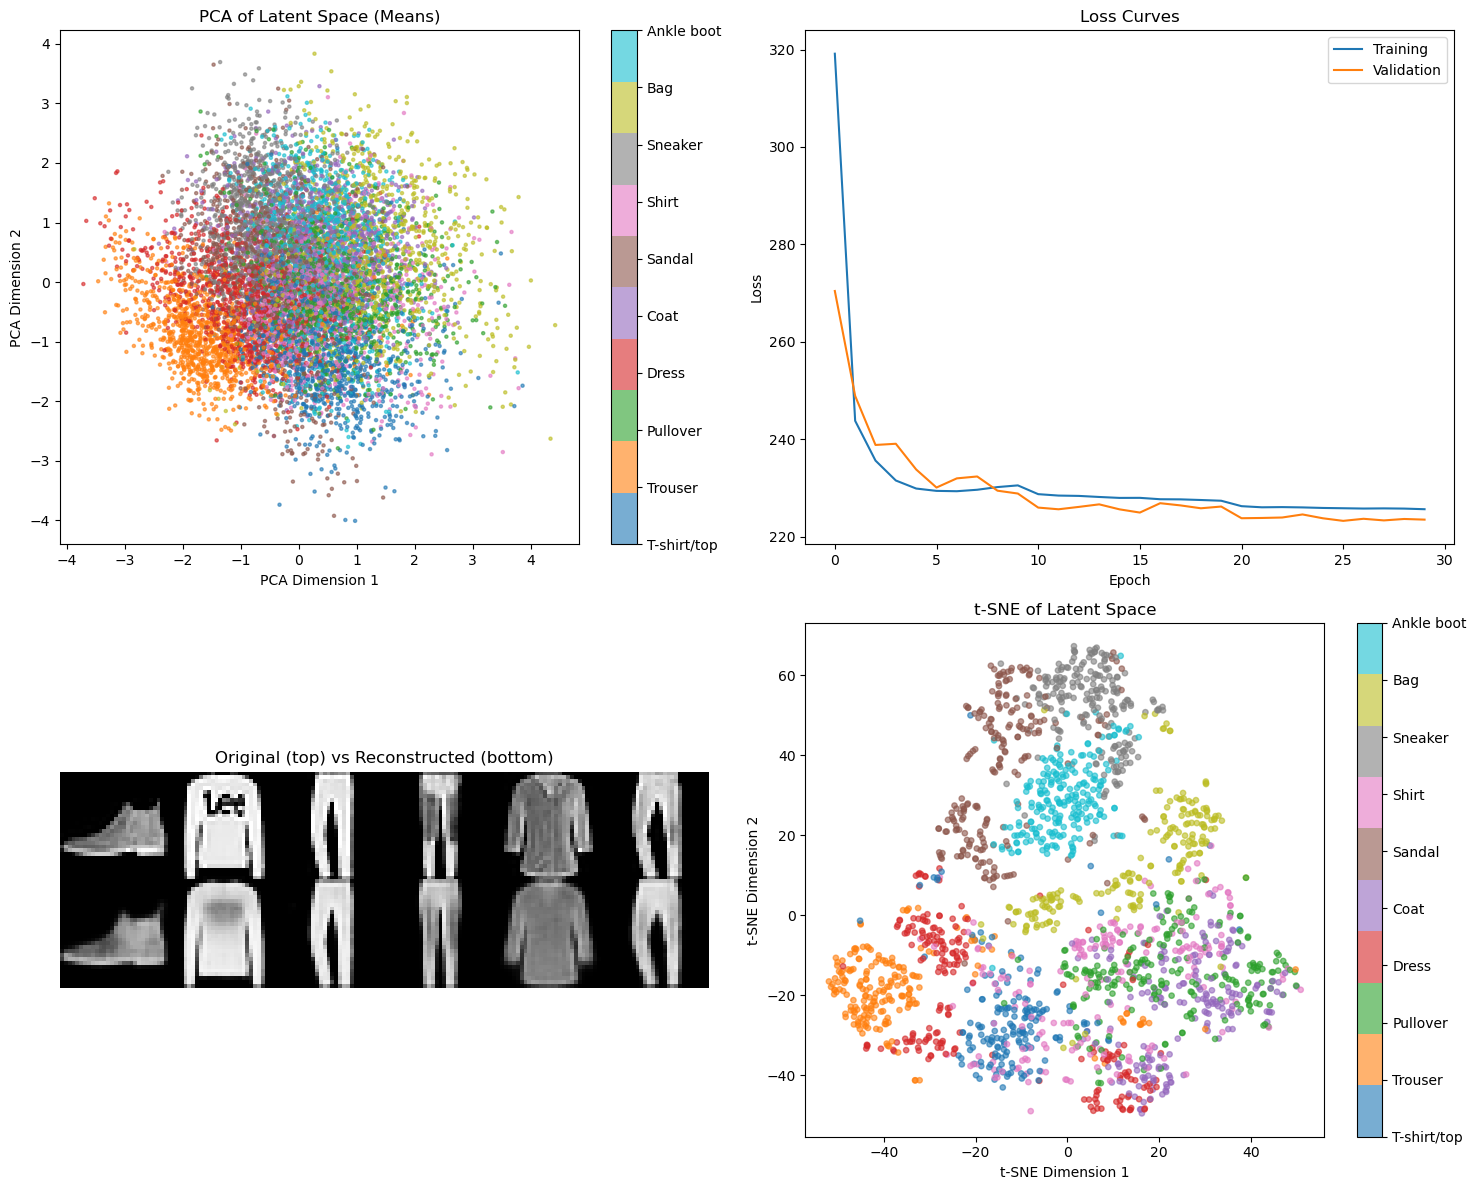


Latent space classification accuracy: 0.8200

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.75      0.81      0.78       277
     Trouser       0.96      0.93      0.94       304
    Pullover       0.73      0.65      0.69       319
       Dress       0.80      0.86      0.83       296
        Coat       0.68      0.74      0.71       289
      Sandal       0.96      0.85      0.90       303
       Shirt       0.60      0.55      0.58       288
     Sneaker       0.85      0.94      0.90       325
         Bag       0.96      0.94      0.95       285
  Ankle boot       0.92      0.91      0.91       314

    accuracy                           0.82      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.82      0.82      0.82      3000

Process completed!


In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration for Mac with safer fallback
def get_device():
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        try:
            # Test if MPS is actually working
            x = torch.ones(1, device="mps")
            y = x * 2
            y.to("cpu")  # Test data transfer
            print("Using MPS (Apple Silicon GPU)")
            return torch.device("mps")
        except Exception as e:
            print(f"MPS is available but encountered an error: {e}")
            print("Falling back to CPU")
            return torch.device("cpu")
    elif torch.cuda.is_available():
        print("Using CUDA GPU")
        return torch.device("cuda")
    else:
        print("Using CPU")
        return torch.device("cpu")

device = get_device()

# Hyperparameters
batch_size = 256  # large batch size for speed. i didnt know macs can be this fast lol...
latent_dim = 16
epochs = 30
learning_rate = 0.005
weight_decay = 2e-5
beta = 0.5

# Load Fashion MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

# Define VAE model with simplified architecture
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder - simpler architecture to avoid MPS issues
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # 14x14
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 7x7
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # 7x7
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        
        # Flatten and dense layers
        self.encoder_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2)
            
        
        )
        
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        
        # Decoder
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 64 * 7 * 7),
            nn.LeakyReLU(0.2)
        )
        
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14x14
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 28x28
            nn.Sigmoid()
        )
    
    def encode(self, x):
        x = self.encoder_conv(x)
        x = self.encoder_fc(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        # More stable version of reparameterization for Mac
        std = torch.exp(0.5 * logvar)
        # Use a more explicit approach for random sampling that works better on MPS
        if device.type == "mps":
            # Generate random values on CPU then move to MPS
            eps = torch.randn_like(std, device="cpu").to(device)
        else:
            eps = torch.randn_like(std)
        z = mu + eps * std
        return z
        
    def decode(self, z):
        # Decoder with more explicit reshaping for MPS compatibility
        z = self.decoder_fc(z)
        batch_size = z.size(0)
        # More explicit reshape that works better with MPS
        z = z.view(batch_size, 64, 7, 7)
        z = self.decoder_conv(z)
        return z
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstruction = self.decode(z)
        return reconstruction, mu, logvar
    
    def get_latent_space(self, x):
        with torch.no_grad():
            mu, logvar = self.encode(x)
            z = self.reparameterize(mu, logvar)
        return mu, z

# Define the loss function with error handling
def vae_loss(recon_x, x, mu, logvar, beta):
    try:
        # Binary cross entropy (sum reduction for numerical stability)
        BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
        # KL divergence
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + beta * KLD
    except RuntimeError as e:
        print(f"Error in loss calculation: {e}")
        # Return a default tensor if an error occurs
        return torch.tensor(1000.0, device=device, requires_grad=True)

# Create model, optimizer with safer handling
try:
    model = VAE(latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
except Exception as e:
    print(f"Error setting up model or optimizer: {e}")
    raise

# Training loop with error handling
def train(epoch):
    model.train()
    train_loss = 0
    processed_batches = 0
    
    # Beta annealing
    current_beta = min(beta, beta * min(1.0, epoch / 10.0))
    
    for batch_idx, (data, _) in enumerate(train_loader):
        try:
            data = data.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            recon_batch, mu, logvar = model(data)
            
            # Compute loss
            loss = vae_loss(recon_batch, data, mu, logvar, current_beta)
            
            # Backward pass
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            processed_batches += 1
            
            if batch_idx % 100 == 0:
                print(f'Epoch {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                      f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
                
        except RuntimeError as e:
            print(f"Error in batch {batch_idx}: {e}")
            # Skip this batch and continue
            continue
    
    # Calculate average loss
    if processed_batches > 0:
        avg_loss = train_loss / (processed_batches * batch_size)
    else:
        avg_loss = float('inf')
        
    print(f'Epoch {epoch}: Average loss: {avg_loss:.4f}, Beta: {current_beta:.3f}')
    return avg_loss

# Validation function with error handling
def validate():
    model.eval()
    val_loss = 0
    processed_batches = 0
    
    with torch.no_grad():
        for data, _ in test_loader:
            try:
                data = data.to(device)
                recon_batch, mu, logvar = model(data)
                # Add loss for this batch
                val_loss += vae_loss(recon_batch, data, mu, logvar, beta).item()
                processed_batches += 1
            except RuntimeError as e:
                print(f"Error in validation: {e}")
                continue
    
    # Calculate average validation loss
    if processed_batches > 0:
        avg_val_loss = val_loss / (processed_batches * batch_size)
    else:
        avg_val_loss = float('inf')
        
    print(f'Validation Loss: {avg_val_loss:.4f}')
    return avg_val_loss

# Training with safer handling
print("Training VAE on Fashion MNIST...")
losses = []
val_losses = []

try:
    for epoch in range(1, epochs + 1):
        loss = train(epoch)
        losses.append(loss)
        
        val_loss = validate()
        val_losses.append(val_loss)
        
        # Update learning rate
        scheduler.step()
        
        print(f'Current learning rate: {optimizer.param_groups[0]["lr"]}')
        
        # Save model checkpoint
        if epoch % 5 == 0:
            torch.save(model.state_dict(), f'vae_checkpoint_epoch_{epoch}.pt')
            print(f"Saved checkpoint at epoch {epoch}")
            
except KeyboardInterrupt:
    print("Training interrupted by user")
except Exception as e:
    print(f"Error during training: {e}")
    # Save the model before exiting
    torch.save(model.state_dict(), 'vae_checkpoint_interrupted.pt')
    print("Saved model checkpoint despite error")

# Get latent space representations with safer approach
print("Generating latent space visualization...")
model.eval()

# Lists to store latent variables and labels
all_mu = []
all_z = []
all_labels = []

# Process in smaller batches to avoid memory issues
with torch.no_grad():
    for data, labels in test_loader:
        try:
            data = data.to(device)
            mu, z = model.get_latent_space(data)
            
            # Move tensors to CPU immediately to free up GPU memory
            all_mu.append(mu.cpu().numpy())
            all_z.append(z.cpu().numpy())
            all_labels.append(labels.numpy())
        except Exception as e:
            print(f"Error in latent space generation: {e}")
            continue

# Concatenate batches
try:
    all_mu = np.concatenate(all_mu, axis=0)
    all_z = np.concatenate(all_z, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
except ValueError as e:
    print(f"Error concatenating results: {e}")
    # If concatenation fails, exit visualization gracefully
    print("Skipping visualization due to errors")
    import sys
    sys.exit(1)

# Create class names for Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Visualization with dimensionality reduction
try:
    from sklearn.decomposition import PCA
    
    # Apply PCA for visualization
    print("Applying PCA to visualize the latent space...")
    pca = PCA(n_components=2)
    all_mu_pca = pca.fit_transform(all_mu)
    all_z_pca = pca.fit_transform(all_z)
    
    plt.figure(figsize=(15, 12))
    
    # First plot: PCA of means
    plt.subplot(2, 2, 1)
    plt.scatter(all_mu_pca[:, 0], all_mu_pca[:, 1], c=all_labels, cmap='tab10', alpha=0.6, s=5)
    cbar = plt.colorbar(ticks=range(10))
    cbar.set_ticklabels(class_names)
    plt.title('PCA of Latent Space (Means)')
    plt.xlabel('PCA Dimension 1')
    plt.ylabel('PCA Dimension 2')
    print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.2f}")
    
    # Second plot: Plot the loss curves
    plt.subplot(2, 2, 2)
    plt.plot(losses, label='Training')
    plt.plot(val_losses, label='Validation')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Third plot: Visualize reconstructions
    with torch.no_grad():
        # Get some test examples
        test_examples, _ = next(iter(test_loader))
        n_examples = 6
        test_examples = test_examples[:n_examples].to(device)
        
        # Reconstruct
        reconstructions, _, _ = model(test_examples)
        
        # Convert to numpy for plotting
        test_examples = test_examples.cpu().numpy()
        reconstructions = reconstructions.cpu().numpy()
    
    # Plot side by side
    plt.subplot(2, 2, 3)
    fig_size = 28
    recon_figure = np.zeros((fig_size * 2, fig_size * n_examples))
    
    for i in range(n_examples):
        # Original
        recon_figure[0:fig_size, i*fig_size:(i+1)*fig_size] = test_examples[i][0]
        # Reconstruction
        recon_figure[fig_size:fig_size*2, i*fig_size:(i+1)*fig_size] = reconstructions[i][0]
    
    plt.imshow(recon_figure, cmap='gray')
    plt.title('Original (top) vs Reconstructed (bottom)')
    plt.axis('off')
    
    # Fourth plot: t-SNE visualization (on a subset for speed)
    plt.subplot(2, 2, 4)
    try:
        from sklearn.manifold import TSNE
        subset_size = min(2000, len(all_mu))
        indices = np.random.choice(len(all_mu), subset_size, replace=False)
        
        # t-SNE with lower perplexity for more distinct clusters
        tsne = TSNE(n_components=2, perplexity=25, n_iter=1000, learning_rate='auto', init='pca')
        all_mu_tsne = tsne.fit_transform(all_mu[indices])
        
        plt.scatter(all_mu_tsne[:, 0], all_mu_tsne[:, 1], c=all_labels[indices], 
                   cmap='tab10', alpha=0.6, s=15)
        cbar = plt.colorbar(ticks=range(10))
        cbar.set_ticklabels(class_names)
        plt.title('t-SNE of Latent Space')
        plt.xlabel('t-SNE Dimension 1')
        plt.ylabel('t-SNE Dimension 2')
    except Exception as e:
        print(f"Error in t-SNE visualization: {e}")
        # If t-SNE fails, show latent space quality instead
        plt.text(0.5, 0.5, "t-SNE failed, see console for error", 
                 horizontalalignment='center', verticalalignment='center')
    
    plt.tight_layout()
    plt.savefig('fashion_mnist_vae_visualization.png')
    plt.show()
    
    # Analyze latent space quality with a classifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report
    
    # Split data 
    X_train, X_test, y_train, y_test = train_test_split(
        all_mu, all_labels, test_size=0.3, random_state=42
    )
    
    # Train a KNN classifier on the latent space
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    
    # Evaluate
    y_pred = knn.predict(X_test)
    accuracy = (y_pred == y_test).mean()
    
    print(f"\nLatent space classification accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=class_names))
    
except Exception as e:
    print(f"Error in visualization: {e}")
    
print("Process completed!")

## How we draw samples from a VAE and inteprolation between two drawn samples

Using MPS (Apple Silicon GPU)
Model loaded from vae_checkpoint_epoch_30.pt
Sample 1 latent space representation: [ 0.9046778   0.22267687  0.1460281   0.7360334  -0.41420847 -0.11061821
  0.45399758 -3.3259435  -0.23074764 -0.91871226  0.24642573  1.0245827
 -0.08279499 -0.81583977 -0.19103353  0.6188665 ]


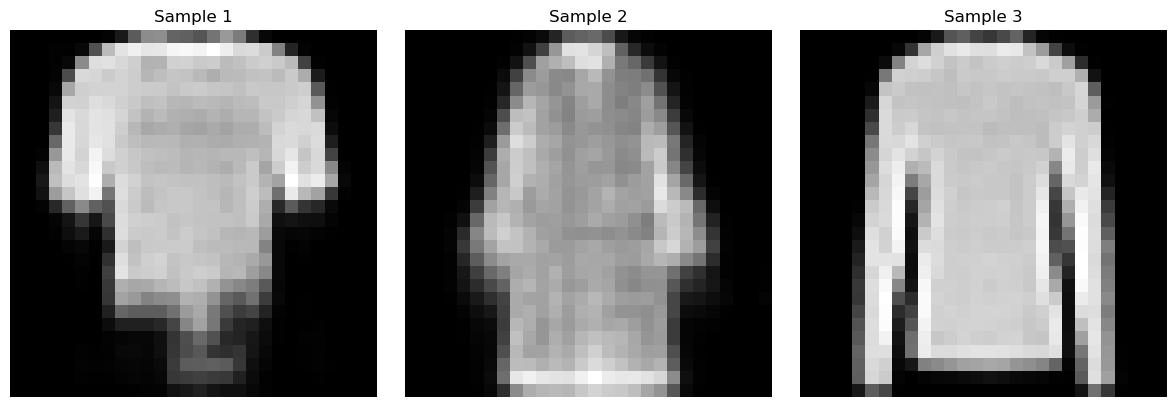

Samples generated successfully!
Generating interpolated samples...


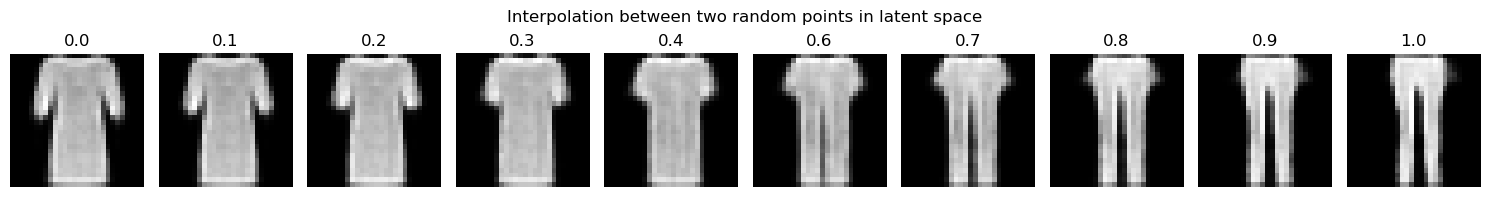

In [38]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Get the appropriate device
device = get_device()

# Hyperparameters (matching your original code)
latent_dim = 16

def generate_samples(model, num_samples=3, save_path='vae_generated_samples.png'):
    """
    Generate random samples from the VAE decoder
    
    Args:
        model: Trained VAE model
        num_samples: Number of samples to generate
        save_path: Path to save the figure
    """
    # Set model to evaluation mode
    model.eval()
    
    # Create a figure
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 4, 4))
    
    with torch.no_grad():  # No need to track gradients
        for i in range(num_samples):
            # Sample random noise from a normal distribution
            z = torch.randn(1, latent_dim, device=device)
            
            if i ==0: 
                # drawing the first sample
                print(f"Sample {i+1} latent space representation: {z.squeeze().cpu().numpy()}")
            
            # Decode the random noise to generate a sample
            sample = model.decode(z)
            
            # Convert to numpy and reshape
            sample_np = sample.squeeze().cpu().numpy()
            
            # Plot the sample
            if num_samples > 1:
                ax = axes[i]
            else:
                ax = axes
                
            ax.imshow(sample_np, cmap='gray')
            ax.set_title(f'Sample {i+1}')
            ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    
    return sample_np  # Return the last sample for reference

# Load the trained model
def load_and_sample(checkpoint_path='vae_checkpoint_epoch_30.pt'):
    """
    Load a trained VAE model and generate samples
    
    Args:
        checkpoint_path: Path to the model checkpoint
    """
    try:
        # Initialize model
        model = VAE(latent_dim).to(device)
        
        # Load the state dict
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        print(f"Model loaded from {checkpoint_path}")
        
        # Generate samples
        samples = generate_samples(model)
        print("Samples generated successfully!")
        
        return model
        
    except Exception as e:
        print(f"Error loading model or generating samples: {e}")
        return None

# Alternative approach: Interpolate between samples
def generate_interpolated_samples(model, num_steps=10, save_path='vae_interpolation.png'):
    """
    Generate samples by interpolating between two random points in latent space
    
    Args:
        model: Trained VAE model
        num_steps: Number of interpolation steps
        save_path: Path to save the figure
    """
    model.eval()
    
    # Create two random points in latent space
    z1 = torch.randn(1, latent_dim, device=device)
    z2 = torch.randn(1, latent_dim, device=device)
    
    # Create a figure
    fig, axes = plt.subplots(1, num_steps, figsize=(num_steps * 1.5, 2))
    
    with torch.no_grad():
        for i in range(num_steps):
            # Interpolation factor
            alpha = i / (num_steps - 1)
            
            # Interpolate between z1 and z2
            z = z1 * (1 - alpha) + z2 * alpha
            
            # Decode the interpolated point
            sample = model.decode(z)
            
            # Convert to numpy and reshape
            sample_np = sample.squeeze().cpu().numpy()
            
            # Plot the sample
            axes[i].imshow(sample_np, cmap='gray')
            axes[i].set_title(f'{alpha:.1f}')
            axes[i].axis('off')
    
    plt.suptitle('Interpolation between two random points in latent space')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

# Execute the code
if __name__ == "__main__":
    # Try to load the last checkpoint first
    model = load_and_sample('vae_checkpoint_epoch_30.pt')
    
    # If that fails, try the interrupted checkpoint
    if model is None:
        model = load_and_sample('vae_checkpoint_interrupted.pt')
    
    # If we have a model, show the interpolation as well
    if model is not None:
        print("Generating interpolated samples...")
        generate_interpolated_samples(model)

What's the dist of the embedded dataset:

Using MPS (Apple Silicon GPU)
Loaded model from vae_checkpoint_epoch_30.pt
Computing embeddings for training set...
Computing embeddings for test set...
Training embeddings shape: (60000, 16)
Test embeddings shape: (10000, 16)
Saved visualization to vae_embedding_distribution.png


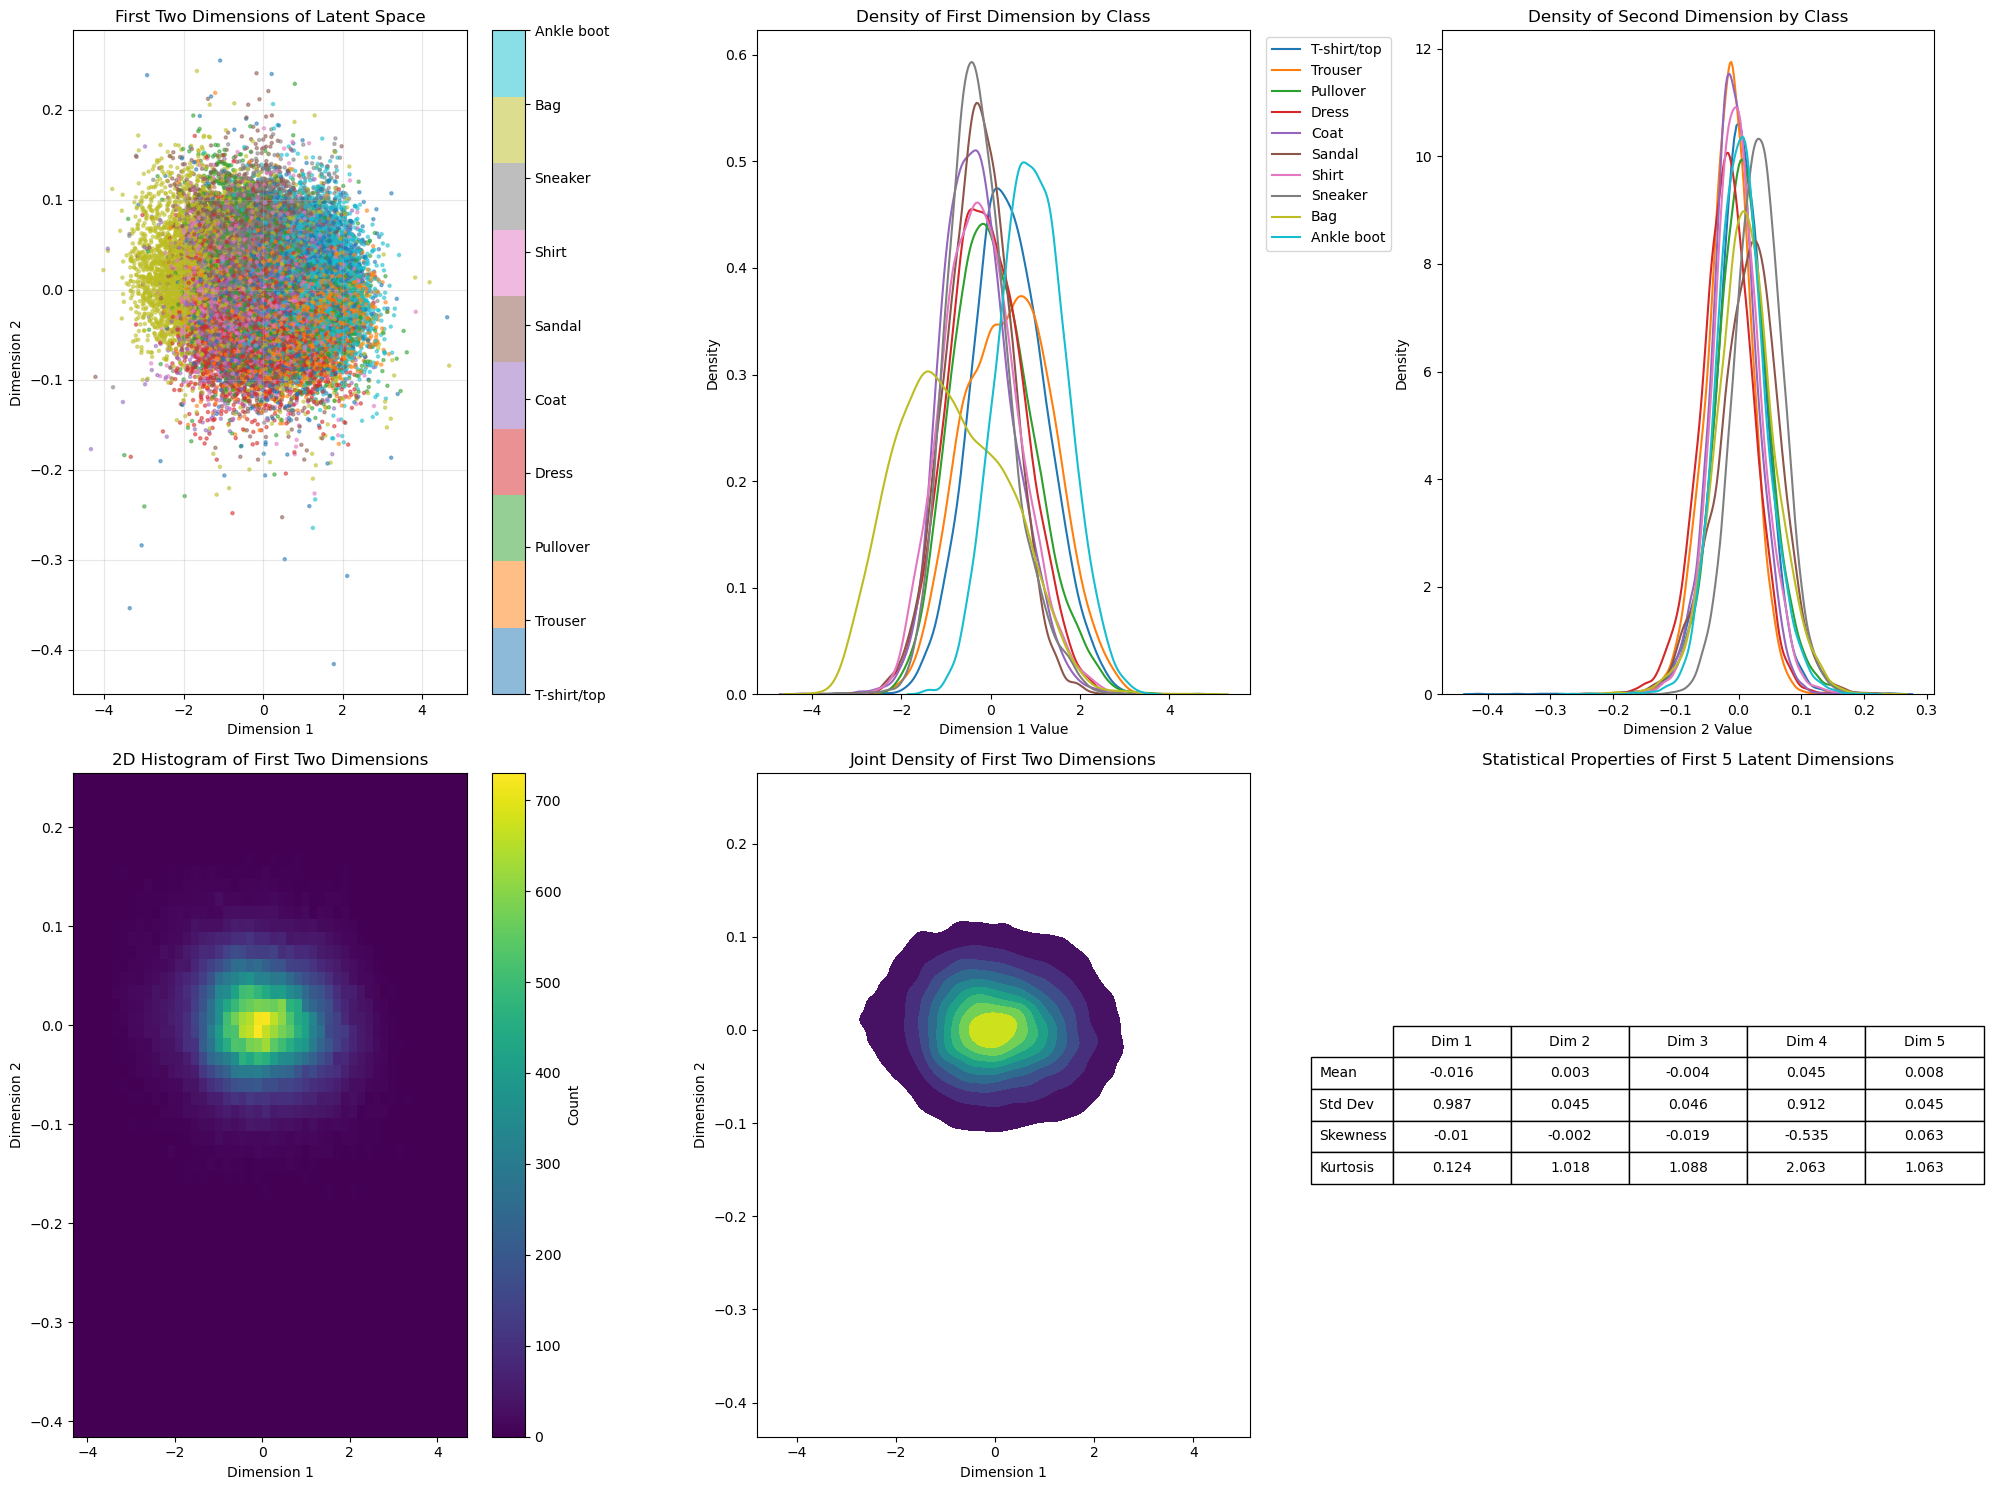

Saved correlation matrix to vae_embedding_correlation.png
Saved embeddings to disk


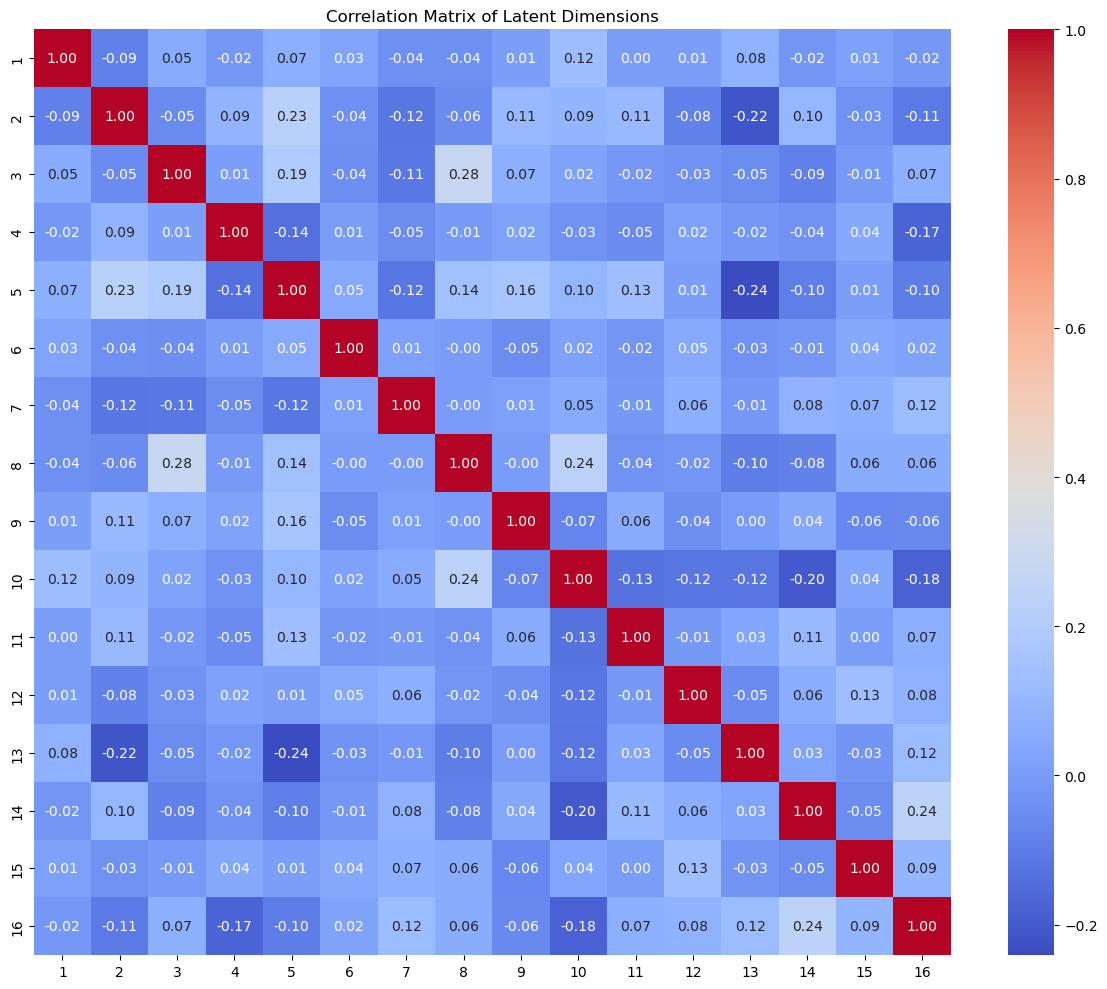

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from scipy import stats

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration for Mac with safer fallback
def get_device():
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        try:
            # Test if MPS is actually working
            x = torch.ones(1, device="mps")
            y = x * 2
            y.to("cpu")  # Test data transfer
            print("Using MPS (Apple Silicon GPU)")
            return torch.device("mps")
        except Exception as e:
            print(f"MPS is available but encountered an error: {e}")
            print("Falling back to CPU")
            return torch.device("cpu")
    elif torch.cuda.is_available():
        print("Using CUDA GPU")
        return torch.device("cuda")
    else:
        print("Using CPU")
        return torch.device("cpu")

device = get_device()

# Hyperparameters
batch_size = 256
latent_dim = 16

# Load Fashion MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # No shuffle for consistent ordering
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Class names for Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Define VAE model with the same architecture as in your training code
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # 14x14
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 7x7
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # 7x7
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        
        # Flatten and dense layers
        self.encoder_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2)
        )
        
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        
        # Decoder (not needed for embedding extraction but included for completeness)
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 64 * 7 * 7),
            nn.LeakyReLU(0.2)
        )
        
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14x14
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 28x28
            nn.Sigmoid()
        )
    
    def encode(self, x):
        x = self.encoder_conv(x)
        x = self.encoder_fc(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        if device.type == "mps":
            eps = torch.randn_like(std, device="cpu").to(device)
        else:
            eps = torch.randn_like(std)
        z = mu + eps * std
        return z
        
    def decode(self, z):
        z = self.decoder_fc(z)
        batch_size = z.size(0)
        z = z.view(batch_size, 64, 7, 7)
        z = self.decoder_conv(z)
        return z
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstruction = self.decode(z)
        return reconstruction, mu, logvar
    
    def get_latent_space(self, x):
        with torch.no_grad():
            mu, logvar = self.encode(x)
            z = self.reparameterize(mu, logvar)
        return mu, z

def main():
    try:
        # Load the pre-trained model
        # Change the path to your saved model checkpoint
        model_path = 'vae_checkpoint_epoch_30.pt'  # update this to your latest checkpoint
        
        # Create and load the model
        model = VAE(latent_dim).to(device)
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
        
        print(f"Loaded model from {model_path}")
        
        # Function to compute embeddings for a dataset
        def compute_embeddings(data_loader, model):
            all_embeddings = []
            all_labels = []
            
            with torch.no_grad():
                for data, labels in data_loader:
                    try:
                        data = data.to(device)
                        # Get the mean vector (mu) from the encoder
                        mu, _ = model.encode(data)
                        
                        # Move to CPU immediately to free GPU memory
                        all_embeddings.append(mu.cpu().numpy())
                        all_labels.append(labels.numpy())
                    except Exception as e:
                        print(f"Error processing batch: {e}")
                        continue
            
            # Concatenate all batches
            try:
                all_embeddings = np.concatenate(all_embeddings, axis=0)
                all_labels = np.concatenate(all_labels, axis=0)
                return all_embeddings, all_labels
            except ValueError as e:
                print(f"Error concatenating embeddings: {e}")
                return None, None
        
        # Compute embeddings for train and test sets
        print("Computing embeddings for training set...")
        train_embeddings, train_labels = compute_embeddings(train_loader, model)
        
        print("Computing embeddings for test set...")
        test_embeddings, test_labels = compute_embeddings(test_loader, model)
        
        if train_embeddings is None or test_embeddings is None:
            print("Failed to compute embeddings")
            return
        
        print(f"Training embeddings shape: {train_embeddings.shape}")
        print(f"Test embeddings shape: {test_embeddings.shape}")
        
        # Combine train and test for overall distribution
        all_embeddings = np.vstack((train_embeddings, test_embeddings))
        all_labels = np.concatenate((train_labels, test_labels))
        
        # Create plots
        plt.figure(figsize=(20, 15))
        
        # 1. Scatter plot of first two dimensions
        plt.subplot(2, 3, 1)
        scatter = plt.scatter(all_embeddings[:, 0], all_embeddings[:, 1], c=all_labels, 
                   cmap='tab10', alpha=0.5, s=5)
        plt.colorbar(scatter, ticks=range(10)).set_ticklabels(class_names)
        plt.title('First Two Dimensions of Latent Space')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.grid(True, alpha=0.3)
        
        # 2. Kernel Density Estimation of first dimension
        plt.subplot(2, 3, 2)
        for i in range(10):
            class_data = all_embeddings[all_labels == i, 0]
            sns.kdeplot(class_data, label=class_names[i])
        plt.title('Density of First Dimension by Class')
        plt.xlabel('Dimension 1 Value')
        plt.ylabel('Density')
        plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
        
        # 3. Kernel Density Estimation of second dimension
        plt.subplot(2, 3, 3)
        for i in range(10):
            class_data = all_embeddings[all_labels == i, 1]
            sns.kdeplot(class_data, label=class_names[i])
        plt.title('Density of Second Dimension by Class')
        plt.xlabel('Dimension 2 Value')
        plt.ylabel('Density')
        
        # 4. 2D histogram (heatmap) of first two dimensions
        plt.subplot(2, 3, 4)
        plt.hist2d(all_embeddings[:, 0], all_embeddings[:, 1], bins=50, cmap='viridis')
        plt.colorbar(label='Count')
        plt.title('2D Histogram of First Two Dimensions')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        
        # 5. Joint KDE plot of first two dimensions (overall)
        plt.subplot(2, 3, 5)
        sns.kdeplot(x=all_embeddings[:, 0], y=all_embeddings[:, 1], 
                   cmap="viridis", fill=True, thresh=0.05)
        plt.title('Joint Density of First Two Dimensions')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        
        # 6. Statistical properties
        plt.subplot(2, 3, 6)
        # Calculate mean, std, skewness, kurtosis
        means = np.mean(all_embeddings[:, :5], axis=0)
        stds = np.std(all_embeddings[:, :5], axis=0)
        skewness = stats.skew(all_embeddings[:, :5], axis=0)
        kurtosis = stats.kurtosis(all_embeddings[:, :5], axis=0)
        
        # Create a table to display the statistics
        dim_names = [f'Dim {i+1}' for i in range(5)]
        stat_data = np.vstack([means, stds, skewness, kurtosis])
        
        plt.axis('off')
        table = plt.table(cellText=stat_data.round(3), 
                         rowLabels=['Mean', 'Std Dev', 'Skewness', 'Kurtosis'],
                         colLabels=dim_names,
                         loc='center', cellLoc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.5)
        plt.title('Statistical Properties of First 5 Latent Dimensions')
        
        plt.tight_layout()
        plt.savefig('vae_embedding_distribution.png', dpi=300, bbox_inches='tight')
        print("Saved visualization to vae_embedding_distribution.png")
        plt.show()
        
        # Compute correlation matrix
        plt.figure(figsize=(12, 10))
        corr_matrix = np.corrcoef(all_embeddings.T)
        sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", 
                   xticklabels=range(1, latent_dim+1), 
                   yticklabels=range(1, latent_dim+1))
        plt.title('Correlation Matrix of Latent Dimensions')
        plt.tight_layout()
        plt.savefig('vae_embedding_correlation.png', dpi=300)
        print("Saved correlation matrix to vae_embedding_correlation.png")
        
        # Save embeddings for future use
        np.save('train_embeddings.npy', train_embeddings)
        np.save('train_labels.npy', train_labels)
        np.save('test_embeddings.npy', test_embeddings)
        np.save('test_labels.npy', test_labels)
        print("Saved embeddings to disk")
        
    except Exception as e:
        print(f"Error in main function: {e}")

if __name__ == "__main__":
    main()

# so for a moderately well trained VAE the emirical distribution of the embedded dataset is approximately normal. 


this makes sense as we are implying the shape of $q_\theta$ when minimising ELBO. 


What claude has to say about it: 


What makes VAEs special is that they don't just encode data points deterministically like regular autoencoders. Instead, the encoder outputs parameters (mean and variance) of a Gaussian distribution for each input. The VAE's loss function includes a KL divergence term that explicitly encourages these latent distributions to be close to a standard normal distribution (with mean 0 and variance 1).
This normal distribution prior serves several purposes:

It regularizes the latent space, preventing overfitting
It enables smooth interpolation between data points
It allows for straightforward random sampling from the latent space for generation

In practice, the normality might not be perfect, especially if:

The dataset has complex underlying structure
The dimensionality of the latent space is insufficient
The model prioritizes reconstruction quality over latent space regularity

But generally, a well-trained VAE should have its embedded data following an approximately normal distribution in the latent space.
